In [1]:
# biblioteki
!pip install pandas matplotlib --quiet
!pip install tensorflow --quiet
!pip install mlxtend --upgrade --no-deps --quiet

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlxtend

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam

from platform import python_version


print(f"""
    PYTHON VERSION:      {python_version()}
    NUMPY VERSION:       {np.__version__}
    PANDAS VERSION:      {pd.__version__}
    TENSERFLOW VERSION:  {tf.__version__}
    KERAS VERSION:       {keras.__version__}
    MLEXTEND VERSION:    {mlxtend.__version__}
""")

2022-05-19 12:12:31.334336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 12:12:31.334381: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



    PYTHON VERSION:      3.8.10
    NUMPY VERSION:       1.22.3
    PANDAS VERSION:      1.4.2
    TENSERFLOW VERSION:  2.8.0
    KERAS VERSION:       2.8.0
    MLEXTEND VERSION:    0.19.0



In [2]:
# CONSTANTS
C_GREYSCALE = True
C_IMG_SIZE = 48
C_IMG_CHANNELS = 1 if C_GREYSCALE else 0
C_DATASET_SIZE = 10000

In [27]:
from PIL import Image, ImageOps

def load_image(path: str, filename: str, reshape: tuple = (), greyscale: bool = False, normalize: bool = False, mask = False):
    og_image = Image.open(f"{path}/{filename}")
    
    if reshape:
        if mask:
            og_image = og_image.resize(reshape, Image.Resampling.NEAREST)
        else:
            og_image = og_image.resize(reshape)
            
    if greyscale:
        og_image = ImageOps.grayscale(og_image)
    
    return np.array(og_image.getdata(), dtype=int)


print(load_image(f'CelebAMask-HQ/CelebA-HQ-img', f'1.jpg', greyscale = C_GREYSCALE, reshape = (C_IMG_SIZE, C_IMG_SIZE)))

[184 185 186 ... 148 130 136]


In [28]:
def plot_image(pixels: np.ndarray, shape = (1024, 1024, 3)) -> None:
    pixels = np.reshape(pixels, shape)
    plt.imshow(pixels, cmap='gray')

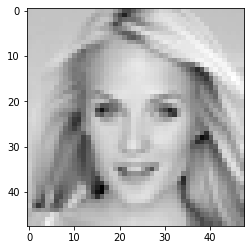

In [29]:
image = load_image(
    f'CelebAMask-HQ/CelebA-HQ-img', f'1.jpg',
    greyscale = C_GREYSCALE, 
    reshape = (C_IMG_SIZE, C_IMG_SIZE)
)
plot_image(image, (C_IMG_SIZE, C_IMG_SIZE, C_IMG_CHANNELS))

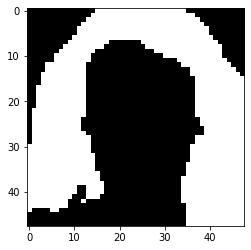

In [30]:
image = load_image(f'CelebAMask-HQ/CelebAMask-HQ-mask-anno/0', f'00001_hair.png', (48, 48), mask=True)
plot_image(image, (48, 48, 3))

In [31]:
%%time
import os
from IPython.display import clear_output

def load_dataset(path: str, limit: int = None, reshape: tuple = (), greyscale: bool = False, normalize: bool = False):
    arrays = []
    subjects = list(set(map(lambda file: file.split('.')[0], os.listdir(f'{path}/CelebA-HQ-img'))))
    subjects.sort(key = int)
    if limit is not None:
        subjects = subjects[:limit]
    for subject in subjects:
        print(subject)
        print(int(subject)//2000)
        clear_output(wait=True)
        try:
            arrays.append([
                load_image(f'{path}/CelebAMask-HQ-mask-anno/{int(subject)//2000}', f'{subject:0>5}_hair.png', greyscale=greyscale, reshape=reshape, mask=True), 
                load_image(f'{path}/CelebA-HQ-img', f'{subject}.jpg', greyscale=greyscale, reshape=reshape)
            ])
        except FileNotFoundError:
            pass
    return np.array(arrays, dtype=object)
    
dataset = load_dataset('CelebAMask-HQ', C_DATASET_SIZE, reshape=(C_IMG_SIZE, C_IMG_SIZE), greyscale=C_GREYSCALE)
print(len(dataset))

8678
CPU times: user 5min 17s, sys: 10.2 s, total: 5min 27s
Wall time: 5min 28s


In [32]:
np.save(f'dataX{C_DATASET_SIZE}x{C_IMG_SIZE}x{C_IMG_SIZE}x{C_IMG_CHANNELS}.npy', dataset) # save

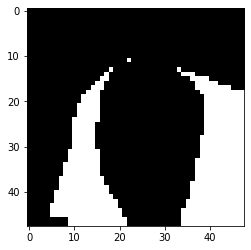

In [33]:
data = np.load(f'dataX{C_DATASET_SIZE}x{C_IMG_SIZE}x{C_IMG_SIZE}x{C_IMG_CHANNELS}.npy', allow_pickle=True)
# print(data[:, 1].tolist())
# data2d = pd.DataFrame({'HairMask': data[:, 0].tolist(), 'Pixels': data[:, 1].tolist()})

plot_image(data[6].tolist()[0], (C_IMG_SIZE, C_IMG_SIZE, 1))

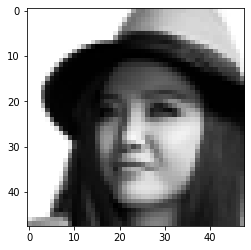

In [34]:
plot_image(data[6].tolist()[1], (C_IMG_SIZE, C_IMG_SIZE, C_IMG_CHANNELS))

In [35]:
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU
from tensorflow.compat.v1.keras import backend as K

In [36]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred = int(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        proc.append(score)
    return K.mean(K.stack(prec), axis=0)

In [39]:
def unet_model():
    img_size = C_IMG_SIZE
    img_channels = C_IMG_CHANNELS
    inputs = Input((img_size, img_size, img_channels))
    s = Lambda(lambda x: x)(inputs)
    
    # DOWN SAMPLING
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    c1 = Dropout(0.3)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.3)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.3)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # BOTTOM OF U-NET
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    
    # UP SAMPLING
    u6 = Conv2DTranspose(img_size, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(img_size >> 1, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)   
    
    u8 = Conv2DTranspose(img_size >> 2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(img_size >> 3, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
#     print(model.summary())
    
    return model

model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

In [40]:
# tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

epochs = 50
images = data[:, 0]
images = images.reshape((images.shape[0], C_IMG_SIZE, C_IMG_SIZE, C_IMG_CHANNELS))
images = np.asarray(images).astype('float32')
images = images/255

masks = data[:, 1]
masks = masks.reshape((masks.shape[0], C_IMG_SIZE, C_IMG_SIZE, C_IMG_CHANNELS))
masks = np.asarray(masks).astype('float32')
masks = masks/255

history = model.fit(images, masks, validation_split=0.2, epochs=epochs, batch_size=25)
model.save('model_iou.h5')

Epoch 1/50
278/278 [==============================] - 428s 2s/step - loss: 0.6595 - mean_io_u: 0.4972 - val_loss: 0.6540 - val_mean_io_u: 0.4970
Epoch 2/50
278/278 [==============================] - 439s 2s/step - loss: 0.6533 - mean_io_u: 0.4972 - val_loss: 0.6508 - val_mean_io_u: 0.4970
Epoch 3/50
278/278 [==============================] - 426s 2s/step - loss: 0.6506 - mean_io_u: 0.4972 - val_loss: 0.6509 - val_mean_io_u: 0.4970
Epoch 4/50
278/278 [==============================] - 476s 2s/step - loss: 0.6496 - mean_io_u: 0.4972 - val_loss: 0.6472 - val_mean_io_u: 0.4970
Epoch 5/50
269/278 [============================>.] - ETA: 15s - loss: 0.6493 - mean_io_u: 0.4972

KeyboardInterrupt: 

In [ ]:
image = load_image(
    f'CelebAMask-HQ/CelebA-HQ-img', f'1.jpg', 
    greyscale=C_GREYSCALE, 
    reshape=(C_IMG_SIZE, C_IMG_SIZE)
)
image = image.reshape((C_IMG_SIZE, C_IMG_SIZE, C_IMG_CHANNELS))
image = np.asarray(image).astype('float32')
image = image/255

predictions = model.predict(image.tolist())